In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from fund.fund import Fund

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
market = Market()

In [3]:
delta_fund = Fund()
delta_fund.initialize()

In [4]:
market.connect()
sp100 = market.retrieve("sp100")
market.disconnect()

In [5]:
analysis = []
for strategy in tqdm(delta_fund.strategies):
    try:
        parameters = strategy.pull_iterations().to_dict("records")
        for parameter in tqdm(parameters):
            try:
                trade = strategy.db.query("trades",{"iteration":parameter["iteration"]})
                if trade.index.size > 0:
                    positions = int(strategy.positions) if strategy.pricer_class.asset_class.value == "stocks" else 1
                    pricer_timeframe =  strategy.pricer_class.time_horizon_class.naming_convention
                    trade = trade[trade["position"] <= positions]
                    ledger = trade.sort_values("date").copy()
                    ledger = ledger[(ledger["date"]>=delta_fund.start) & (ledger["date"]<=delta_fund.end)]
                    anas = strategy.analysis
                    if ledger.index.size > 0:
                        cumulative = anas.trade_analysis(ledger,positions)
                        for key in parameter.keys():
                            cumulative[key] = parameter[key]
                        cumulative["strategy"] = strategy.name
                        analysis.append(cumulative[list(parameter.keys()) + ["strategy","pv"]].iloc[-1])
            except Exception as e:
                print(str(e))
                continue
        strategy.db.disconnect()
    except Exception as e:
        print(str(e))
a = pd.DataFrame([x.to_dict() for x in analysis])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.55it/s]


In [6]:
a.sort_values("pv",ascending=False).head(20)

,constituent,value,ceiling,classification,rank,floor,buy_day,iteration,strategy,pv
15,100,False,1,False,False,0,1,7,strategy_qsrp_qsrc_qser_b_r,6.977404
23,100,False,1,False,False,0,1,7,strategy_qsrp_qsrc_qsdr_b_r,6.977404
21,100,False,1,True,False,0,1,5,strategy_qsrp_qsrc_qsdr_b_r,6.177085
13,100,False,1,True,False,0,1,5,strategy_qsrp_qsrc_qser_b_r,6.177085
5,100,False,1,True,False,0,1,5,strategy_qsrp_qsrc_qsrr_b_r,5.652147
7,100,False,1,False,False,0,1,7,strategy_qsrp_qsrc_qsrr_b_r,5.614496
37,100,False,1,True,False,0,1,5,strategy_qswp_qsrc_qser_b_r,4.710713
47,100,False,1,False,False,0,1,7,strategy_qswp_qsrc_qsdr_b_r,4.710713
45,100,False,1,True,False,0,1,5,strategy_qswp_qsrc_qsdr_b_r,4.710713
39,100,False,1,False,False,0,1,7,strategy_qswp_qsrc_qser_b_r,4.710713


In [7]:
top_by_strategy = a[a["constituent"]==100].sort_values("pv",ascending=False).groupby("strategy").nth(0).reset_index().sort_values("pv",ascending=False)

In [8]:
top_by_strategy

,strategy,constituent,value,ceiling,classification,rank,floor,buy_day,iteration,pv
0,strategy_qsrp_qsrc_qsdr_b_r,100,False,1,False,False,0,1,7,6.977404
1,strategy_qsrp_qsrc_qser_b_r,100,False,1,False,False,0,1,7,6.977404
2,strategy_qsrp_qsrc_qsrr_b_r,100,False,1,True,False,0,1,5,5.652147
3,strategy_qswp_qsrc_qsdr_b_r,100,False,1,False,False,0,1,7,4.710713
4,strategy_qswp_qsrc_qser_b_r,100,False,1,True,False,0,1,5,4.710713
5,strategy_qswp_qsrc_qsrr_b_r,100,False,1,False,False,0,1,7,3.994641


In [9]:
for row in top_by_strategy.iterrows():
    algo_name = row[1]["strategy"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()
    db.cloud_connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [10]:
cumulatives = []
ledgers = []
for row in top_by_strategy.iterrows():
    name = row[1]["strategy"]
    iteration = row[1]["iteration"]
    db = ADatabase(name)
    db.connect()
    analysis = db.query("trades",{"iteration":int(iteration)})
    db.disconnect()
    ledger = analysis[["date","ticker","actual_returns","position"]]
    ledger = ledger[(ledger["date"]>=delta_fund.start) & (ledger["date"]<=delta_fund.end)]
    ledger = ledger.merge(sp100[["ticker","GICS Sector"]],on="ticker",how="left")
    ledger["strategy"] = name
    ledgers.append(ledger)
    portfolio = ledger.pivot_table(index="date",columns="position",values="actual_returns").fillna(1).reset_index()
    positions = ledger["position"].max()
    cumulative = anas.iteration_analysis(portfolio,positions)
    cumulative["strategy"] = name
    for i in range(positions):
        if i not in cumulative.columns:
            cumulative[i] = 1
        cumulative.rename(columns={i:str(i)},inplace=True)
    db.cloud_connect()
    db.drop("performance")
    db.store("performance",cumulative)
    db.disconnect()
    cumulatives.append(cumulative)

In [11]:
portfolio = pd.concat(cumulatives).pivot_table(index="date",columns="strategy",values="pv").fillna(method="ffill").fillna(1).reset_index()
portfolio["pv"] = [sum([row[1][strategy]*(1/top_by_strategy.index.size) for strategy in portfolio.columns if strategy not in ["date"]]) for row in portfolio.iterrows()]

In [12]:
portfolio[["date","pv"]].tail(1)

strategy,date,pv
24,2023-03-21 04:00:00,5.816342


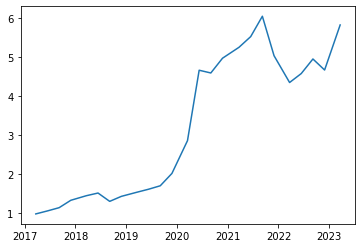

In [13]:
plt.plot(portfolio["date"],portfolio["pv"])

In [14]:
all_ledgers = pd.concat(ledgers)

In [15]:
all_ledgers.groupby(["strategy","GICS Sector"]).mean().reset_index().sort_values("actual_returns",ascending=False)

,strategy,GICS Sector,actual_returns,position
12,strategy_qsrp_qsrc_qser_b_r,Consumer Discretionary,1.189303,2.962963
1,strategy_qsrp_qsrc_qsdr_b_r,Consumer Discretionary,1.189303,2.962963
23,strategy_qsrp_qsrc_qsrr_b_r,Consumer Discretionary,1.139958,3.176471
44,strategy_qswp_qsrc_qser_b_r,Consumer Discretionary,1.131358,3.741935
33,strategy_qswp_qsrc_qsdr_b_r,Consumer Discretionary,1.131358,3.741935
...,...,...,...,...
16,strategy_qsrp_qsrc_qser_b_r,Health Care,1.012343,4.763158
31,strategy_qsrp_qsrc_qsrr_b_r,Utilities,1.006972,6.500000
59,strategy_qswp_qsrc_qsrr_b_r,Health Care,1.003607,5.216216
24,strategy_qsrp_qsrc_qsrr_b_r,Consumer Staples,0.990900,5.200000
